In [1]:
# Import necessary libraries
import emcee
import numpy as np
from multiprocessing import Pool, cpu_count
import copy
import time
from astropy.cosmology import FlatwCDM
import astropy.units as u
from astropy.table import Table

from matplotlib import pyplot as plt

from likelihoods_parallel import log_prior, log_probability, log_likelihood, run_mcmc_analysis
from likelihoods_parallel import beta_double_source_plane, beta2theta_e_ratio
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam

import corner
from chainconsumer import Chain
from chainconsumer import ChainConsumer
from chainconsumer import PlotConfig
from chainconsumer import ChainConfig
from chainconsumer.plotting import plot_contour
import os

In [2]:
# define a cosmology
cosmology = "FwCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
om_true = 0.3
w_true = -1
h0_true = 70
kwargs_cosmo_true = {"h0": h0_true, "om": om_true, "w": w_true}  # cosmological model of the forecast

# create astropy.cosmology instance of input cosmology
cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

gamma_pl_mean = 2.05
gamma_pl_sigma = 0.05

lambda_mst_mean = 1
lambda_mst_sigma = 0.05

def draw_lens_from_given_zs(z_lens, z1, z2, lambda_mst_mean, lambda_mst_sigma, gamma_pl_mean, gamma_pl_sigma, sigma_beta, 
              down_sampling=1, with_noise=False):
    """
    draw the likelihood object of a double source plane lens
    
    :param down_sampling: downsampling factor, noise will be reduced by sqrt(down_sampling)
    """
    beta = beta_double_source_plane(z_lens, z1, z2, cosmo_true)
    
    beta_e_list = []
    beta_e_mean = beta2theta_e_ratio(beta_dsp=beta, gamma_pl=gamma_pl_mean, lambda_mst=lambda_mst_mean)
    for i in range(100):
        lambda_mst = np.random.normal(lambda_mst_mean, lambda_mst_sigma)
        gamma_pl = np.random.normal(gamma_pl_mean, gamma_pl_sigma)
        beta_e_ = beta2theta_e_ratio(beta_dsp=beta, gamma_pl=gamma_pl, lambda_mst=lambda_mst)
        beta_e_list.append(beta_e_)
    beta_e_list = np.array(beta_e_list)
    beta_e_mean_ = np.mean(beta_e_list)
    beta_e_sigma = np.sqrt(np.std(beta_e_list)**2 + (sigma_beta * beta_e_mean)**2) / np.sqrt(down_sampling)
    if with_noise:
        beta_measured = beta_e_mean + np.random.normal(loc=0, scale=beta_e_sigma)
    else:
        beta_measured = beta_e_mean

    kwargs_likelihood = {
        "z_D": z_lens,
        "z_S1": z1,
        "z_S2": z2,
        "theta_E1_by_theta_E2": beta_measured,
        "theta_E1_by_theta_E2_err": beta_e_sigma,
        "likelihood_type": "DSPL",
    }
    return kwargs_likelihood

In [5]:
# Define data files and their labels

# Tables must have the following columns:
# 'z_D1', 'z_D2', 'z_S1', 'z_S2', 
# 'theta_E1_by_theta_E2'

# =====================================
# Settings for population of DSPLs
# =====================================
# number of double source plane lenses
num_dspl = 100

sigma_beta_dspl = 0.1  # relative precision on Einstein radius ratio

kwargs_dspl_list = []

for i in range(num_dspl):
    z_lens = np.random.uniform(low=0.1, high=1)
    z1 = 0
    while z1 < z_lens:
        z1 = np.random.normal(2, 1)
    z2 = 0
    while z2 < z_lens:
        z2 = np.random.normal(2, 1)
    if z1 > z2:
        z1, z2 = z2, z1
    kwargs_dspl_list.append(draw_lens_from_given_zs(z_lens, z1, z2,
                                                     lambda_mst_mean, lambda_mst_sigma, gamma_pl_mean, gamma_pl_sigma,
                                                     sigma_beta=sigma_beta_dspl,
                                                     with_noise=True,))
dspl_table = Table(rows=kwargs_dspl_list, names=['z_D', 'z_S1', 'z_S2', 
                                                 'theta_E1_by_theta_E2', 'theta_E1_by_theta_E2_err', 'likelihood_type'])


# =====================================
# Settings for population of DSPLs 2
# =====================================
# number of double source plane lenses
num_dspl = 1000

sigma_beta_dspl = 0.1  # relative precision on Einstein radius ratio

kwargs_dspl_list2 = []

for i in range(num_dspl):
    z_lens = np.random.uniform(low=0.1, high=1)
    z1 = 0
    while z1 < z_lens:
        z1 = np.random.normal(2, 1)
    z2 = 0
    while z2 < z_lens:
        z2 = np.random.normal(2, 1)
    if z1 > z2:
        z1, z2 = z2, z1
    kwargs_dspl_list2.append(draw_lens_from_given_zs(z_lens, z1, z2,
                                                     lambda_mst_mean, lambda_mst_sigma, gamma_pl_mean, gamma_pl_sigma,
                                                     sigma_beta=sigma_beta_dspl,
                                                     with_noise=True,))

dspl_table2 = Table(rows=kwargs_dspl_list2, names=['z_D', 'z_S1', 'z_S2',
                                                  'theta_E1_by_theta_E2', 'theta_E1_by_theta_E2_err', 'likelihood_type'])


data_files = [
    {
        'data_table': dspl_table2,
        'name': "DSPL 2",
        'color': 'blue',
        'sigma_beta_E_true': sigma_beta_dspl
    },
    {
        'data_table': dspl_table,
        'name': "DSPL",
        'color': 'red',
        'sigma_beta_E_true': sigma_beta_dspl
    },
]

/Users/paras/Projects/PDSPL/pdspl-analysis/notebooks/likelihoods_parallel.py:45: RuntimeWarning: invalid value encountered in scalar power
  theta_E_ratio = (beta_dsp * (2 - lambda_mst) - (1 - lambda_mst)) ** (1 / (gamma_pl - 1))
/Users/paras/Projects/PDSPL/pdspl-analysis/notebooks/likelihoods_parallel.py:45: RuntimeWarning: invalid value encountered in scalar power
  theta_E_ratio = (beta_dsp * (2 - lambda_mst) - (1 - lambda_mst)) ** (1 / (gamma_pl - 1))


In [ ]:
# True cosmological parameters
Om_true = 0.3
w_true = -1.0
H0_true = 70.0 # kept fixed
lambda_MST_true = 1.0
gamma_pl_true = 2.0
latex_labels = [r"$\Omega_m$", r"$w$", r"$\lambda_{MST}$", r"$\gamma_{pl}$"]

# MCMC Parameters
ndim = 4
nwalkers = 200
nsteps = 1000
nburn = 200

# Initialize ChainConsumer
cc = ChainConsumer()

# Process each dataset
for data_info in data_files:
    data_table = data_info['data_table']
    name = data_info['name']
    sigma_beta_E_true = data_info.get('sigma_beta_E_true', None)
    
    print(f"\n=== Processing {name} ===")
    
    # Load and process data
    z_lens_arr = data_table['z_D']
    z1_arr = data_table['z_S1']
    z2_arr = data_table['z_S2']
    beta_E_obs_arr = data_table['theta_E1_by_theta_E2']
    beta_E_obs_err_arr = data_table['theta_E1_by_theta_E2_err']
    num_systems = len(z_lens_arr)

    print(f"Relative uncertainty on observed beta_E: {sigma_beta_E_true:.4f}")
    print(f"Number of data systems: {num_systems}")
    
    # Run MCMC analysis
    sampler = run_mcmc_analysis(z_lens_arr, z1_arr, z2_arr, beta_E_obs_arr, beta_E_obs_err_arr,
                                nwalkers=nwalkers, nsteps=nsteps)
    
    # Create chain for ChainConsumer
    chain = Chain.from_emcee(
        sampler,
        latex_labels,
        name=name,
    )
    
    # Add chain to ChainConsumer
    cc.add_chain(chain)

# Add truth values (uncomment if needed)
# cc.add_truth([Om_true, w_true, lambda_MST_true, gamma_pl_true])

# Plot the results
print("\n=== Generating Plots ===")

# Plot walker traces
fig = cc.plotter.plot_walks()
fig.show()

# Plot corner plot with all chains
fig = cc.plotter.plot()
fig.show()

print("Analysis complete!")


=== Processing DSPL 2 ===
Relative uncertainty on observed beta_E: 0.1000
Number of data systems: 1000


/Users/paras/Projects/PDSPL/pdspl-analysis/notebooks/likelihoods_parallel.py:45: RuntimeWarning: invalid value encountered in power
  theta_E_ratio = (beta_dsp * (2 - lambda_mst) - (1 - lambda_mst)) ** (1 / (gamma_pl - 1))


In [69]:
# external priors

sigma_lambda_prior = 0.01
sigma_gamma_prior = 0.01
sigma_omega_m_prior = 0.05


#flat_samples = sampler.get_chain(discard=n_burn, thin=1, flat=True)

#print(joint_chain.samples[r"$\overline{\lambda}_{\rm int}$"])

def add_prior_to_chain(chain):
    chain_weights = copy.deepcopy(chain)
    lambda_int = chain.samples['$\\lambda_{MST}$']
    om = chain.samples['$\\Omega_m$']
    gamma_pl = chain.samples['$\\gamma_{pl}$']
    weights_om = -(om - om_true)**2 / (2*sigma_omega_m_prior**2)
    weights_lambda = -(lambda_int - lambda_mst_mean)**2 / (2*sigma_lambda_prior**2)
    weights_gamma = -(gamma_pl - gamma_pl_mean)**2 / (2*sigma_gamma_prior**2)
    weights = np.exp(weights_gamma + weights_lambda + weights_om)
    weights[weights < 10**(-10)] = 10**(-10)
    chain_weights.samples["weight"] = weights
    chain_weights.name = chain.name+" + deflector prior"
    return chain_weights

dspl_chain = cc.get_chain(cc.get_names()[0])  # Get the first chain (DSPL)
pdspl_chain = cc.get_chain(cc.get_names()[1])  # Get the second chain (PDSPL)
dspl_chain_prior = add_prior_to_chain(dspl_chain)
pdspl_chain_prior = add_prior_to_chain(pdspl_chain)

# Add chains with priors to ChainConsumer
cc.add_chain(dspl_chain_prior)
cc.add_chain(pdspl_chain_prior)

# Plot the results with priors
print("\n=== Generating Plots with Priors ===")


=== Generating Plots with Priors ===


/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_12929/2156894733.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_12929/2156894733.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Analysis complete!


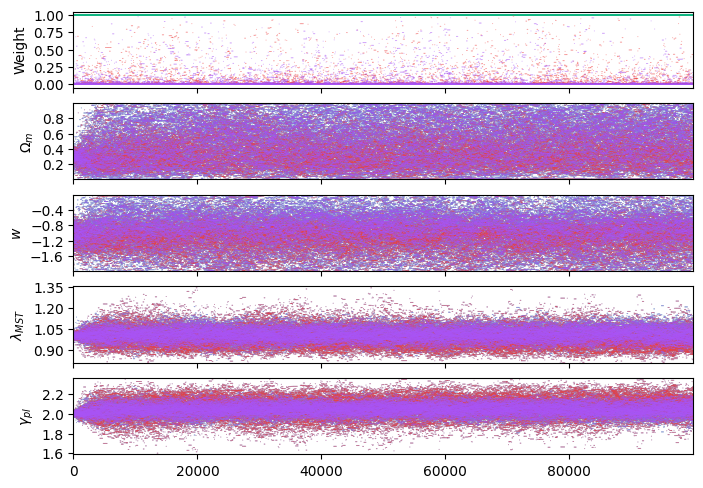

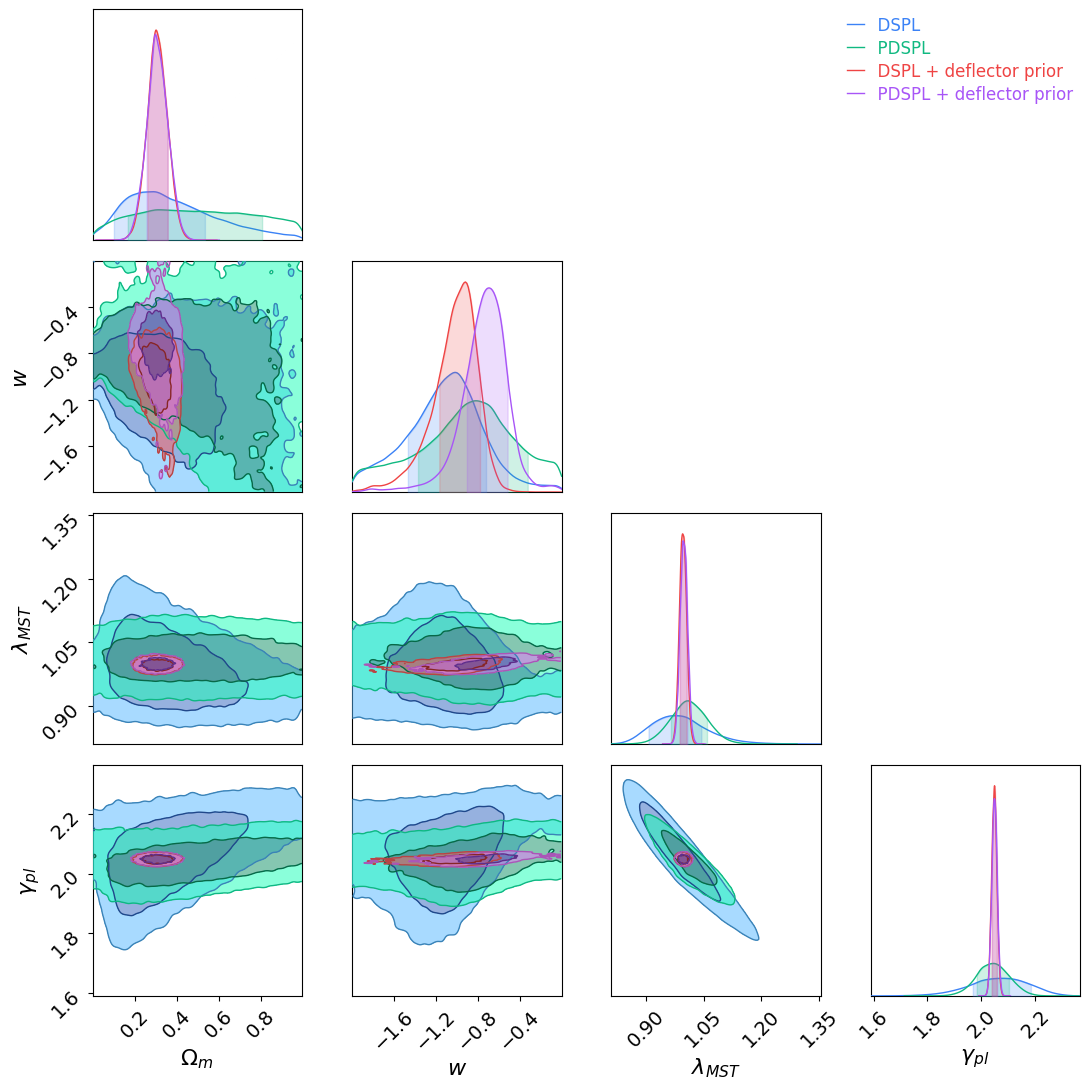

In [72]:
# Plot walker traces
fig = cc.plotter.plot_walks()
fig.show()

# Plot corner plot with all chains
fig = cc.plotter.plot()
fig.show()

# Increase label and tick sizes
for ax in fig.get_axes():
    ax.tick_params(labelsize=14)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

fig.tight_layout()

print("Analysis complete!")

# save the figure
fig.savefig("../figures/DSPL_PDSPL_forecast.pdf", dpi=300, bbox_inches='tight')

In [68]:
cc.remove_chain('DSPL + deflector prior')
cc.remove_chain('PDSPL + deflector prior')